In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [2]:
#data transforms
dset_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.247, 0.243, 0.261])])

batch_size = 64
resnet = 'resnet[3,3,3]'
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=dset_transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=dset_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
class BasicBlock(nn.Module):  # two conv as a res block

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)  # conv1 3x3 filter
        self.bn1 = nn.BatchNorm2d(planes)  # batchnorm
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,  # conv2
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)  # batchnorm

        self.shortcut = nn.Sequential()  # skip connection
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 68 # 64
        self.conv1 = nn.Conv2d(3, 68, kernel_size=2,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(68)
        self.layer1 = self._make_layer(block, 68, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 136, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 272, num_blocks[2], stride=2)
        self.linear = nn.Linear(272, num_classes)
        self.dropout = nn.Dropout(0)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.layer1(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = self.dropout(out)
        out = self.layer3(out)
        out = self.dropout(out)
        out = F.avg_pool2d(out, 7)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        return out


def project1_model():
    return ResNet(BasicBlock, [3,3,3])  # modify

In [5]:
import torch.optim as optim

model = ResNet(BasicBlock, [3,3,3]).cuda()
Loss = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr = 0.1, weight_decay=0.0001)

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

In [8]:
print(count_parameters(model))
epochs = 20
train_save_loss = []
test_save_loss = []
train_save_acc = []
test_save_acc = []
for epoch in range(epochs):
    train_loss = 0.0
    train_corrects = 0.0
    test_loss = 0.0
    test_corrects = 0.0

    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        fit = Loss(outputs, labels)
        fit.backward()
        optimizer.step()

        train_loss += fit.item()
        train_corrects += (torch.eq(torch.max(outputs, 1)[1], labels).sum()).data.cpu().numpy()
    for i, data in enumerate(testloader):
        with torch.no_grad():
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = model(inputs)
            fit = Loss(outputs, labels)
            test_loss += fit.item()
            test_corrects += (torch.eq(torch.max(outputs, 1)[1], labels).sum()).data.cpu().numpy()

    train_loss = train_loss / len(trainloader)
    test_loss = test_loss / len(testloader)
    train_save_loss.append(train_loss)
    test_save_loss.append(test_loss)
    train_corrects = train_corrects / len(trainloader.dataset)
    train_save_acc.append(train_corrects)
    test_corrects = test_corrects / len(testloader.dataset)
    test_save_acc.append(test_corrects)
    print('Epoch %s, Train loss %s, Test loss %s' % (epoch, train_loss, test_loss))
    print("Accuracy ", test_corrects)

4883906
Epoch 0, Train loss 0.0001552483219055623, Test loss 0.5943732708217991
Accuracy  0.8744
Epoch 1, Train loss 0.00014912391088728327, Test loss 0.5918738216541375
Accuracy  0.8746
Epoch 2, Train loss 0.00015310704079836242, Test loss 0.5969990066661957
Accuracy  0.8729
Epoch 3, Train loss 0.00015409828199346772, Test loss 0.5837686292969497
Accuracy  0.8755
Epoch 4, Train loss 0.00014432617762723216, Test loss 0.5819833455192056
Accuracy  0.8761
Epoch 5, Train loss 0.00015408056760233616, Test loss 0.5861344025203377
Accuracy  0.8737
Epoch 6, Train loss 0.00015952126383159162, Test loss 0.5795313863048128
Accuracy  0.8757
Epoch 7, Train loss 0.00015365530338539246, Test loss 0.5737696696238913
Accuracy  0.8748
Epoch 8, Train loss 0.00015319086148624209, Test loss 0.5734202056458801
Accuracy  0.8752
Epoch 9, Train loss 0.0001566213261767212, Test loss 0.569039659515308
Accuracy  0.8741
Epoch 10, Train loss 0.00020800122224977073, Test loss 0.5963545350512122
Accuracy  0.8698
Epoc

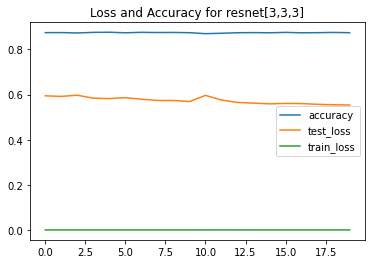

In [18]:
# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt

# %matplotlib inline

plt.plot(test_save_acc)
plt.plot(test_save_loss)
plt.plot(train_save_loss)
plt.legend(["accuracy","test_loss", "train_loss"])
plt.title('Loss and Accuracy for '+resnet)
plt.savefig(resnet+'.png')
torch.save(model.state_dict(), 'project1_model.pt')
